# Mise en place

In [ ]:
import cv2 as cv
print("OpenCV-Python Version {}".format(cv.__version__))
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import math
#from google.colab.patches import cv2_imshow

OpenCV-Python Version 4.8.0


In [ ]:
## Execute this when running the notebook for the first time
from google.colab import drive
drive.mount('/content/drive')
# Then change this to your own folder path containing the notebook
folder_path = "/content/drive/MyDrive/TREC_Codage"

Mounted at /content/drive


In [ ]:
image_file = "IMG_0003.png"
image_path = f"{folder_path}/scan_resultsheets/{image_file}"
# Pour rendre le code plus consistant, la définition de img et gray a été ajoutée dans chaque fonction.
# Les fonctions sont donc appelée avec image_path comme seul paramètre


# Détection des contours des boites

### Test d'une autre méthode de détection des boites

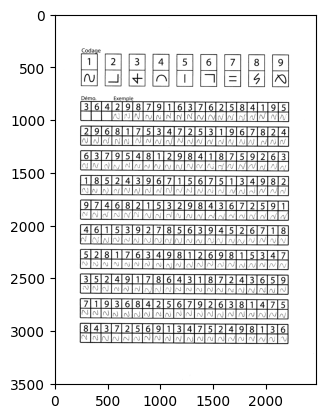

In [ ]:
# Test d'une autre méthode pour détecter les boites

img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
# Appliquer un filtre de seuillage binaire
_, thresh = cv.threshold(img, 190, 255, cv.THRESH_BINARY)
# Appliquer la transformation de Hough pour détecter les lignes droites
lines = cv.HoughLines(thresh, 1, np.pi/180, 100)

plt.imshow(thresh, cmap='gray')
plt.show()

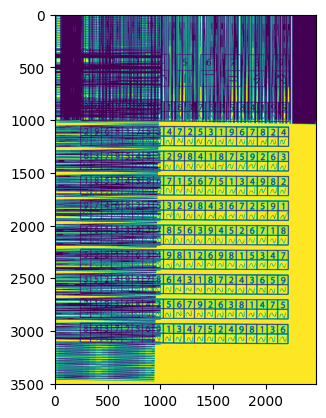

In [ ]:
# Test d'une autre méthode pour détecter les boites

# Parcourir les lignes détectées et filtrer en fonction de la longueur et de l'orientation
min_length = 100
angle_threshold = 1
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    # calculer les coordonnées des deux extrémités de la ligne
    x1 = int(x0 + 1000*(b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(b))
    y2 = int(y0 - 1000*(a))
    length = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    angle = np.degrees(theta)
    if length > min_length and (abs(angle) < angle_threshold or abs(angle-90) < angle_threshold):
        cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Afficher l'image avec les lignes détectées
plt.imshow(img)
plt.show()

### Méthode qui fonctionne pour détecter les boites

#### Fonctions

In [ ]:
# Une fonction pour trouver les carrés.
def extract_boxes(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 170, 250, cv.THRESH_BINARY_INV) # Threshold modifié pour détecter toutes les boites
    plt.imshow(thresh)
    plt.show()
    #contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    extracted_boxes = []
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        if(w>=90 and w<100):
            aspect_ratio = w/h
            if aspect_ratio <= 1.15:
                extracted_boxes.append((x, y, w, h))
    extracted_boxes = np.array(extracted_boxes)
    extracted_boxes = np.flip(extracted_boxes, axis=0)
    return extracted_boxes

In [ ]:
# Une fonction pour afficher les carrés détectés sur le scan de la feuille de résultats
def plot_boxes(img, boxes):
    if boxes.ndim > 1:
        for box in boxes :
            x, y, w, h = box
            cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    else :
        x, y, w, h = boxes
        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.figure(figsize=(10,8))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title("Detected Boxes")
    plt.axis('off')
    plt.show()


In [ ]:
def reorder_box(box):
# Remettre les boites dans l'ordre : gauche -> droite (x), haut -> bas (y)
# Revient a trier sur y croissant puis x croissant
# Pour éviter les petites variations par ligne, on remplace par la moyenne
# Pour chaque ligne et chaque colonne de 20 cases
    boxdf = pd.DataFrame(box, columns = ['x', 'y', 'w', 'h'])
    boxdf_sorted = boxdf.copy()
# S'assurer que la df est bien triée sur les y
    boxdf_sorted = boxdf_sorted.sort_values(by = 'y', ignore_index = True)
    for i in range(0, 400, 20):
        boxdf_sorted.loc[i:i+19, 'y'] = round(boxdf_sorted.loc[i:i+19, 'y'].mean(), 0)
# S'assurer que la df est bien triée sur les x
    boxdf_sorted = boxdf_sorted.sort_values(by = 'x', ignore_index = True)
    for j in range(0, 400, 20):
        boxdf_sorted.loc[j:j+19, 'x'] = round(boxdf_sorted.loc[j:j+19, 'x'].mean(), 0)
# Enfin on retrie par y puis x
    boxdf_sorted = boxdf_sorted.sort_values(by = ['y', 'x'], ignore_index = True)
    box_sorted = boxdf_sorted.to_numpy()
    return box_sorted

In [ ]:
def affiche_scan(img):
    # Affiche le scan avec des lignes horizontales et verticales
    rows,cols, _ = img.shape
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axhline(rows//2, color='r', linewidth=1)
    plt.axvline(cols//2, color='g', linewidth=1)
    plt.show()
def image_rotation(img, degree):
    # Rotate an image of a certain degree counterclockwise
    rows,cols, _ = img.shape
    M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),degree,1)
    img_rot = cv.warpAffine(img,M,(cols,rows))
    affiche_scan(img_rot)
    return img_rot


#### Détection

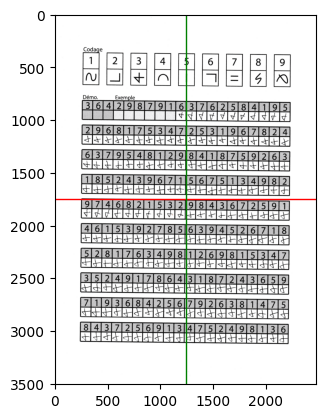

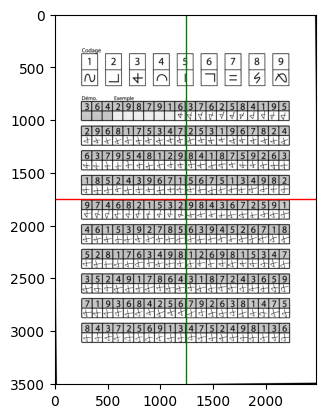

In [ ]:
# Image rotation
img = cv.imread(image_path)
affiche_scan(img)
img_rot = image_rotation(img, 0.6)

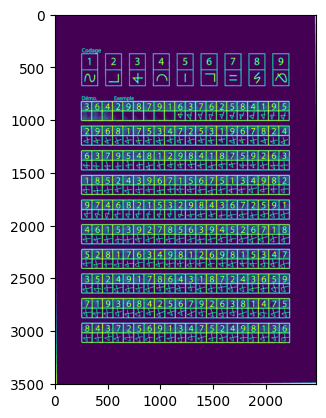

(397, 4)
[1191.48110831 1923.00251889   92.5465995    84.64735516]


In [ ]:
# Création de box : la liste de coordonnées des boites
box = extract_boxes(img_rot)
print(box.shape)
print(box.mean(axis=0))
# Shape doit être (400, 4), sinon ajuster les paramètres des fonctions

In [ ]:
# Do not run if not all boxes are detected
box = reorder_box(box)
print(box.mean(axis=0))

[1191.35516373 1923.07808564   92.5465995    84.64735516]


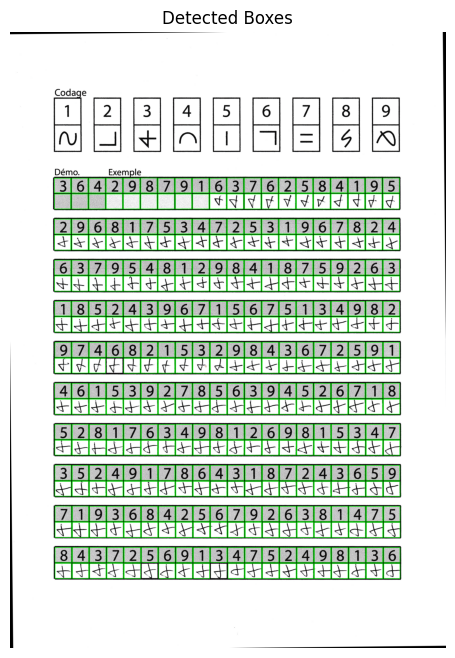

In [ ]:
plot_boxes(img_rot, box)

### Issues

#### #1 Parfois toutes les boites ne sont pas détectées

Cela semble être le cas quand il y a un trou dans la ligne (old/IMG_0003),
ou quand le contenu de la case se superpose avec les limites de la case (old/IMG_0004, new IMG_0003).

* Fix 1: Adapter le code suivant pour qu'il fonctionne sur tous les nombres de boites
* Fix 2: Améliorer la détection des boites avec cv.findcontours

#### #2 Boite qui ressors avec le mauvais index
Résolu par la fonction reorder_box

# Extraction des images (ROI) situées dans les boites

## Fonctions

In [ ]:
# Une fonction pour extraire les roi situées à l'intérieur des boites
arbitrary_width = 87
arbitrary_height = 80
def extract_roi_inside_box(img, box):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    x, y, w, h = box
    roi = gray[y+4:y+arbitrary_height, x+5:x+arbitrary_width]
    #roi = gray[y+4:y+arbitrary_height-4, x+4:x+arbitrary_width-4]
    return roi

In [ ]:
# Liste des index des cases à symboles
intervals = [(20, 40), (60, 80), (100, 120), (140, 160), (180, 200), (220, 240), (260, 280), (300, 320), (340, 360), (380, len(box))]
symbols_index = np.concatenate([np.arange(start, end, 1) for start, end in intervals])
print(symbols_index)
# Liste des index des cases à nombres
all_index = np.arange(0, 400, 1)
number_index = np.setdiff1d(all_index, symbols_index)
print(number_index)

[ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 300 301 302 303
 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  80  81  82  83  84  85  86  87  88  

## Extraction

In [ ]:
# Extraction: création de la liste de toutes les images contenues dans les boites
roi_all = []
for coord in box :
    roi_img = extract_roi_inside_box(img_rot, coord)
    roi_all.append(roi_img)

In [ ]:
# Extraction: création de la liste de toutes les images contenues dans les boites
roi_symbols = []
for coord in box[symbols_index] :
    roi_img = extract_roi_inside_box(img_rot, coord)
    roi_symbols.append(roi_img)

In [ ]:
# Affichage des symboles en lignes de 20
n_rows = math.ceil(len(roi_symbols) / 20)
fig, axs = plt.subplots(n_rows, 20, figsize=(20, n_rows))

for i, pixels in enumerate(roi_symbols):
    row = i // 20
    col = i % 20
    ax = axs[row, col]
    ax.imshow(pixels)
    ax.text(0.5, 1.02, str(i), transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
    ax.axis('off')

plt.show()

NameError: name 'math' is not defined

## Séparation par mean pixel

(397, 76, 82)
(397,)


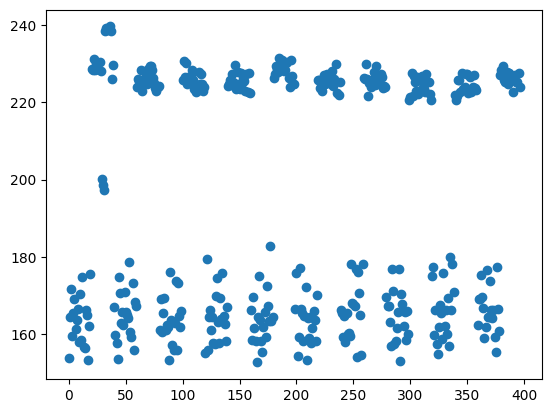

In [ ]:
# Exploration de roi_all
roi_all = np.array(roi_all)
print(roi_all.shape)
mean_pix = roi_all.mean(axis=1).mean(axis=1)
print(mean_pix.shape)
plt.plot(mean_pix, 'o')
# Il est possible que les chiffres puissent être séparés des symboles grâce à la moyenne des pixels

(194, 76, 82)


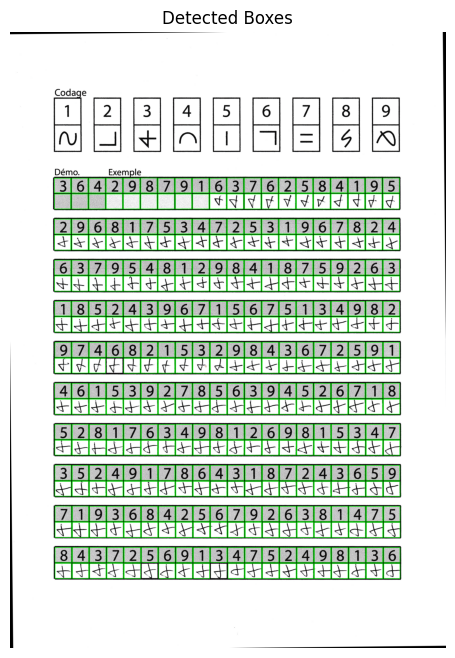

In [ ]:
# Tentative de séparation des chiffres et des symboles
high_mean = np.nonzero(mean_pix > 210)
print(roi_all[high_mean].shape)
plot_boxes(img_rot, box[high_mean])
# Si correct, séparer selon le mean pixel
# Sinon utiliser les indices

In [ ]:
# Pour les cas ou cela fonctionne bien : séparation selon le mean pixel
roi_symbols = roi_all[high_mean].copy()
print(roi_symbols.shape)
roi_numbers = roi_all[~np.isin(np.arange(len(roi_all)), high_mean)].copy()
print(roi_numbers.shape)

(194, 76, 82)
(203, 76, 82)


# Annotation des données

### True label : Feuilles de test (différents symboles)

In [ ]:
# Vrais labels pour les feuilles de test
true_labels = np.array([1, 6, 8, 5, 3, 7, 9, 4, 2, 1, 6, 8, 5, 3, 5, 9, 4, 2, 1, 6,
              4, 9, 3, 1, 2, 6, 7, 5, 8, 4, 9, 3, 1, 2, 6, 7, 5, 8, 4, 9,
              5, 7, 2, 4, 9, 8, 6, 1, 3, 5, 7, 2, 4, 9, 8, 6, 1, 3, 5, 7,
              8, 1, 6, 9, 5, 3, 4, 2, 7, 8, 1, 6, 9, 5, 3, 4, 2, 7, 8, 1,
              3, 5, 7, 2, 4, 1, 8, 6, 9, 3, 5, 7, 2, 4, 1, 8, 6, 9, 3, 5,
              9, 4, 1, 8, 6, 2, 3, 7, 5, 9, 4, 1, 8, 6, 2, 3, 7, 5, 9, 4,
              2, 8, 9, 7, 1, 5, 4, 3, 6, 2, 8, 9, 7, 1, 5, 4, 3, 6, 2, 8,
              7, 3, 4, 6, 8, 9, 2, 1, 5, 7, 3, 4, 6, 8, 9, 2, 1, 5, 7, 3,
              6, 2, 5, 3, 7, 4, 1, 9, 8, 6, 2, 5, 3, 7, 4, 1, 9, 8, 6, 2,
              5, 9, 8, 4, 6, 1, 3, 5, 2, 7, 4, 6, 1, 9, 5, 3, 8, 4, 2, 1])
print(true_labels)

[1 6 8 5 3 7 9 4 2 1 6 8 5 3 5 9 4 2 1 6 4 9 3 1 2 6 7 5 8 4 9 3 1 2 6 7 5
 8 4 9 5 7 2 4 9 8 6 1 3 5 7 2 4 9 8 6 1 3 5 7 8 1 6 9 5 3 4 2 7 8 1 6 9 5
 3 4 2 7 8 1 3 5 7 2 4 1 8 6 9 3 5 7 2 4 1 8 6 9 3 5 9 4 1 8 6 2 3 7 5 9 4
 1 8 6 2 3 7 5 9 4 2 8 9 7 1 5 4 3 6 2 8 9 7 1 5 4 3 6 2 8 7 3 4 6 8 9 2 1
 5 7 3 4 6 8 9 2 1 5 7 3 6 2 5 3 7 4 1 9 8 6 2 5 3 7 4 1 9 8 6 2 5 9 8 4 6
 1 3 5 2 7 4 6 1 9 5 3 8 4 2 1]


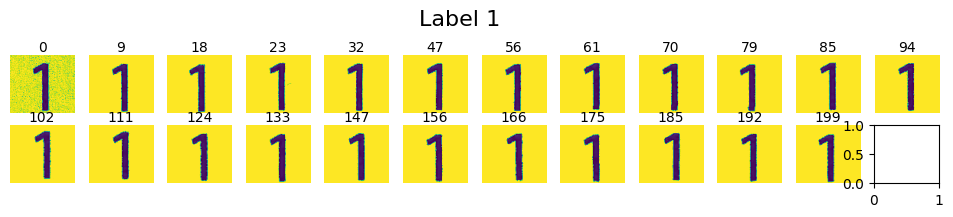

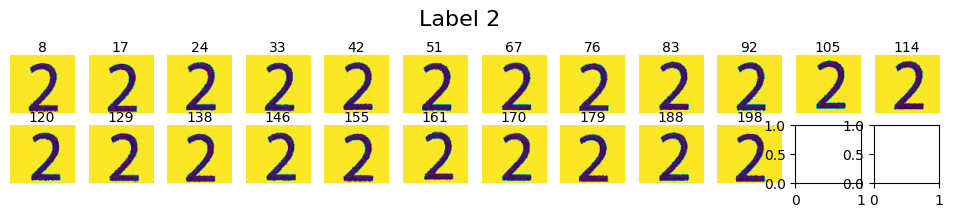

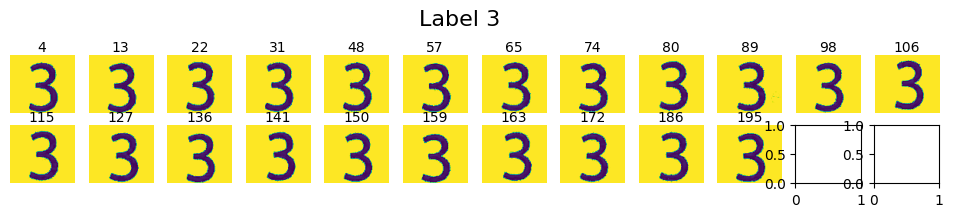

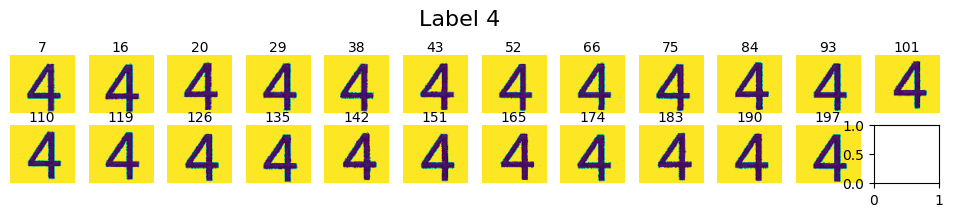

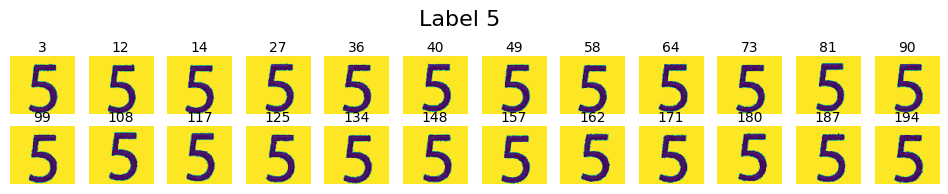

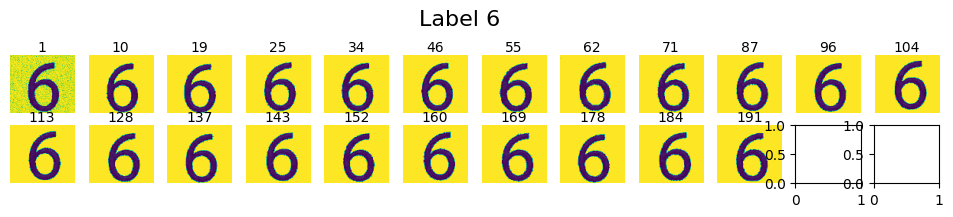

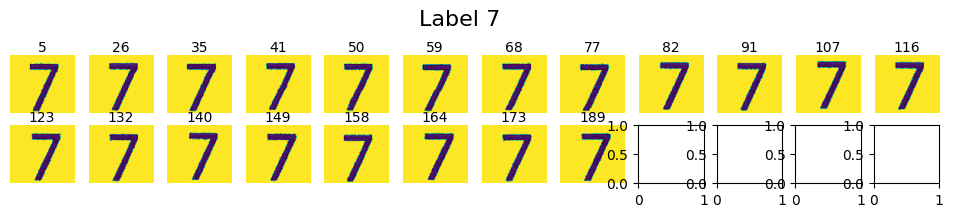

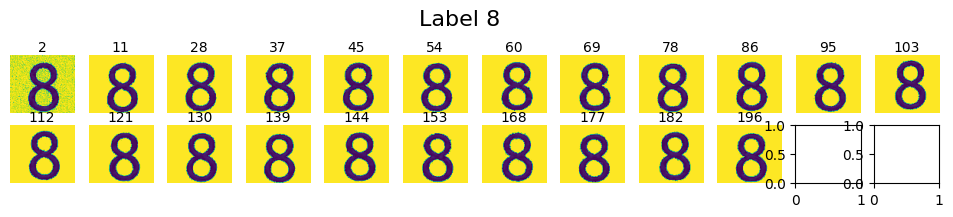

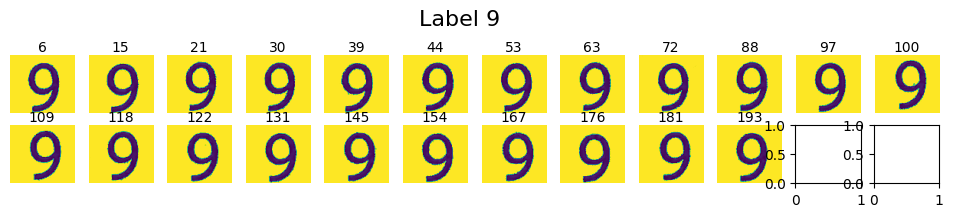

In [ ]:
# Annotation: affichage des nombres affectés à chaque true_label (vérification)
for label in np.unique(true_labels):
    label_mask = (true_labels == label)
    roi_indices = np.where(label_mask)[0]

    n_rows = math.ceil(len(roi_numbers[label_mask]) / 12)
    fig, axs = plt.subplots(n_rows, 12, figsize=(12, n_rows))

    for i, pixels in enumerate(roi_numbers[label_mask]):
        row = i // 12
        col = i % 12
        ax = axs[row, col]
        ax.imshow(pixels)
        ax.text(0.5, 1.02, str(roi_indices[i]), transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
        ax.axis('off')
    fig.suptitle(f'Label {label}', fontsize=16)
    fig.subplots_adjust(top=0.75)
    plt.show()

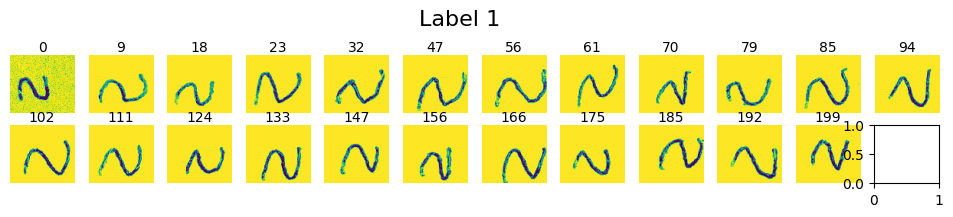

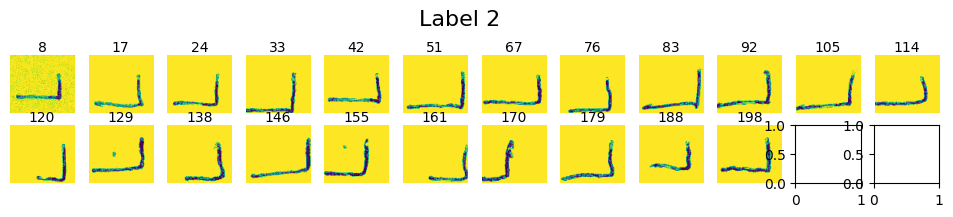

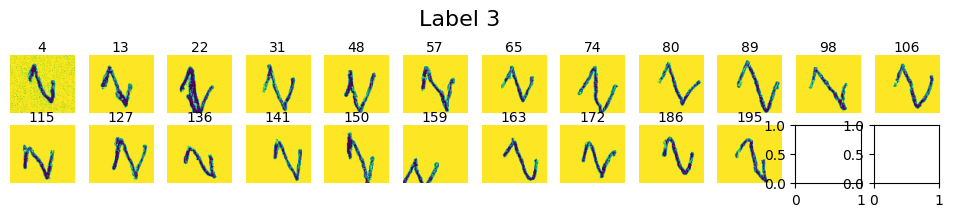

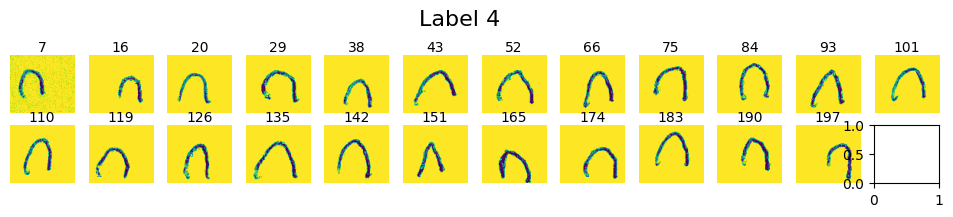

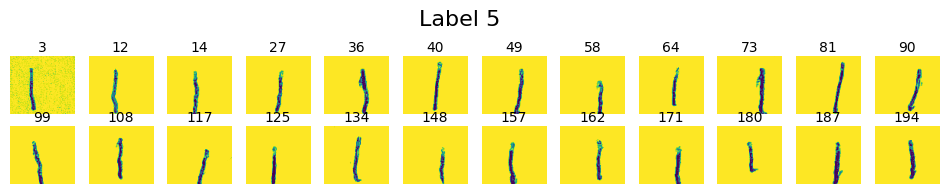

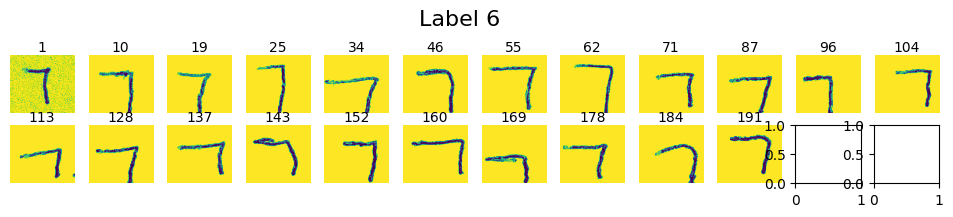

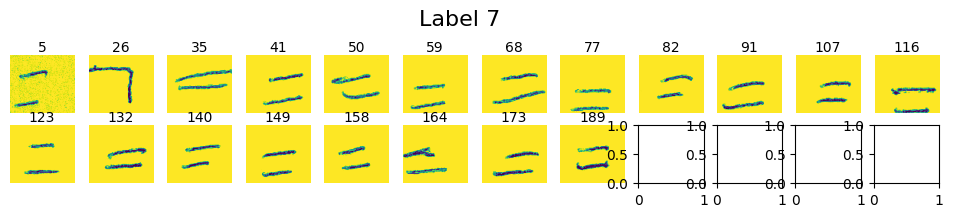

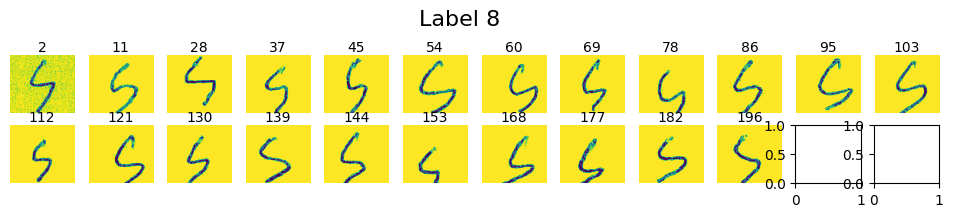

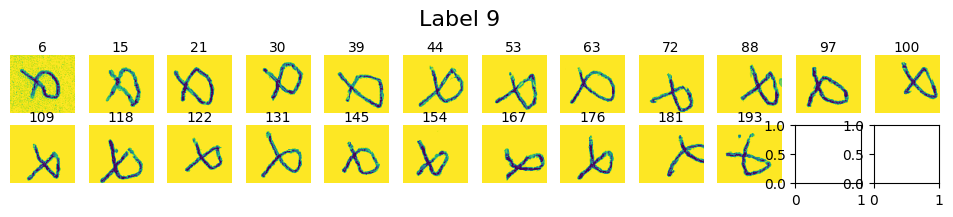

In [ ]:
# Annotation: affichage des symboles affectés à chaque true_label : détection des erreurs
for label in np.unique(true_labels):
    label_mask = (true_labels == label)
    roi_indices = np.where(label_mask)[0]

    n_rows = math.ceil(len(roi_symbols[label_mask]) / 12)
    fig, axs = plt.subplots(n_rows, 12, figsize=(12, n_rows))

    for i, pixels in enumerate(roi_symbols[label_mask]):
        row = i // 12
        col = i % 12
        ax = axs[row, col]
        ax.imshow(pixels)
        ax.text(0.5, 1.02, str(roi_indices[i]), transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
        ax.axis('off')
    fig.suptitle(f'Label {label}', fontsize=16)
    fig.subplots_adjust(top=0.75)
    plt.show()

In [ ]:
# Pour les vraies feuilles de résultats
# Reste a faire l'annotation manuellement : on part des true labels
# Et on corrige en entrant les corrigeant les label pour les indices
# Indiqués sur le graph précédent
annotation_labels = true_labels.copy()
#annotation_labels[np.array([76])] = 1
#annotation_labels[np.array([1])] = 2
#annotation_labels[np.array([65])] = 3
#annotation_labels[np.array([25])] = 4
#annotation_labels[np.array([102, 109])] = 5
annotation_labels[np.array([26])] = 6
#annotation_labels[np.array([50])] = 7
#annotation_labels[np.array([108])] = 9

print(annotation_labels)

[1 6 8 5 3 7 9 4 2 1 6 8 5 3 5 9 4 2 1 6 4 9 3 1 2 6 6 5 8 4 9 3 1 2 6 7 5
 8 4 9 5 7 2 4 9 8 6 1 3 5 7 2 4 9 8 6 1 3 5 7 8 1 6 9 5 3 4 2 7 8 1 6 9 5
 3 4 2 7 8 1 3 5 7 2 4 1 8 6 9 3 5 7 2 4 1 8 6 9 3 5 9 4 1 8 6 2 3 7 5 9 4
 1 8 6 2 3 7 5 9 4 2 8 9 7 1 5 4 3 6 2 8 9 7 1 5 4 3 6 2 8 7 3 4 6 8 9 2 1
 5 7 3 4 6 8 9 2 1 5 7 3 6 2 5 3 7 4 1 9 8 6 2 5 3 7 4 1 9 8 6 2 5 9 8 4 6
 1 3 5 2 7 4 6 1 9 5 3 8 4 2 1]


### Feuilles de training (monosymboles)

In [ ]:
# Vrais labels pour les feuilles de training (monosymboles)
train_label = f'{image_file}'
train_label = int(train_label[-5])
true_labels = np.full((200,), train_label)
print(true_labels)
print(true_labels.dtype)
annotation_labels = true_labels.copy()

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
int64


### Annotation : vérifications

In [ ]:
# Pour les feuilles de training (monosymboles)
# On enlève les cases vides ou avec des erreurs
todelete = list(range(0, 9)) + list([88])
roi_symbols_c = np.delete(roi_symbols, todelete, axis=0)
print(roi_symbols_c.shape)
annotation_labels_c = np.delete(annotation_labels, todelete, axis=0)
print(annotation_labels_c.shape)

(190, 76, 82)
(190,)


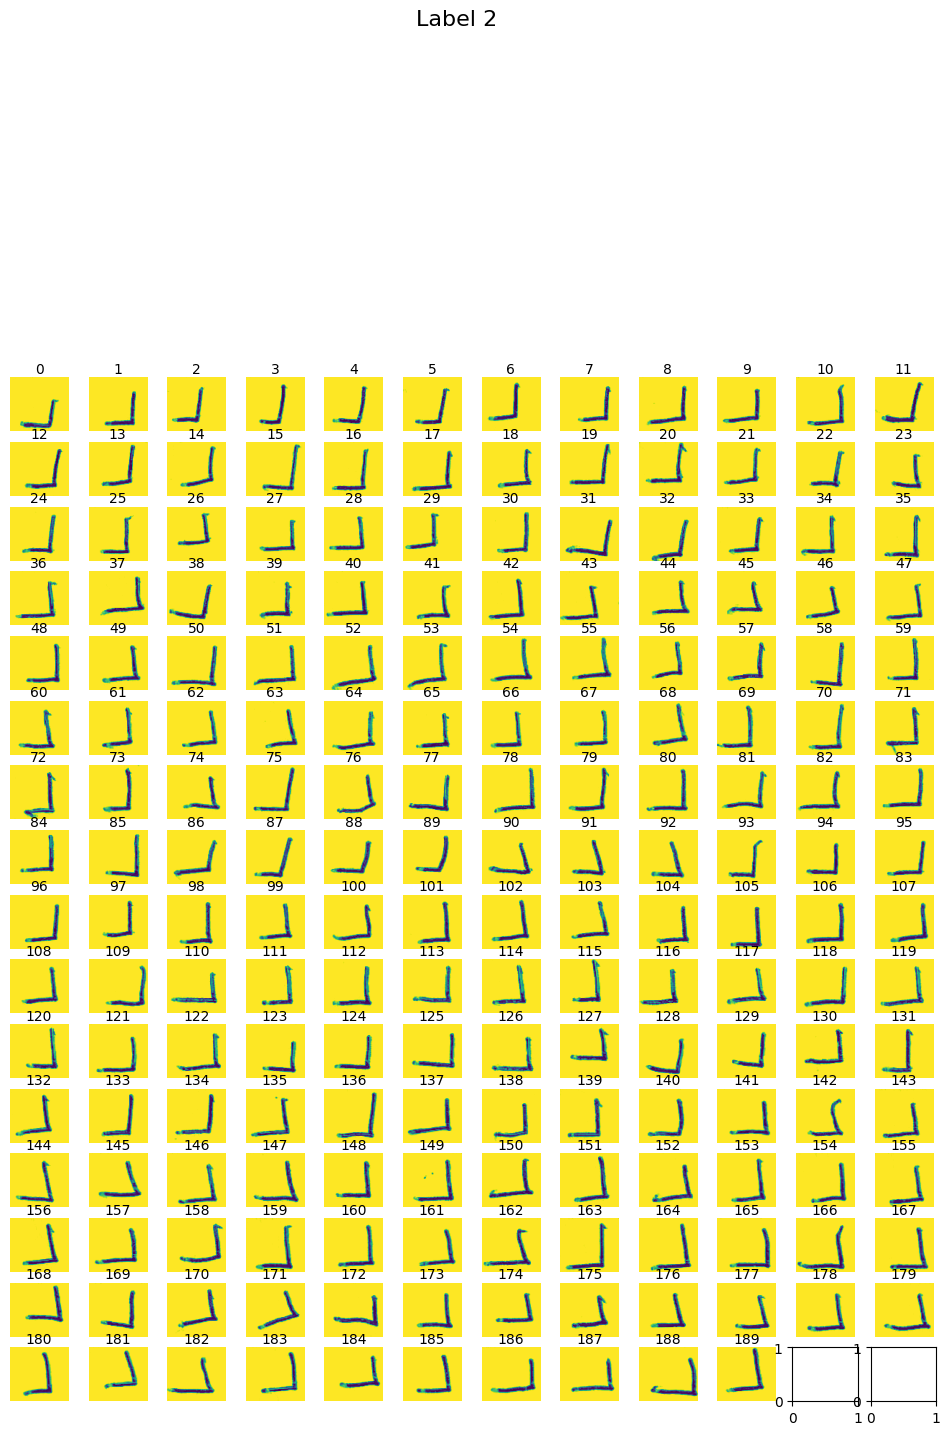

In [ ]:
# Annotation: vérification que l'annotation a bien été faite
for label in np.unique(annotation_labels_c):
    label_mask = (annotation_labels_c == label)
    roi_indices = np.where(label_mask)[0]

    n_rows = math.ceil(len(roi_symbols_c[label_mask]) / 12)
    fig, axs = plt.subplots(n_rows, 12, figsize=(12, n_rows))

    for i, pixels in enumerate(roi_symbols_c[label_mask]):
        row = i // 12
        col = i % 12
        ax = axs[row, col]
        ax.imshow(pixels)
        ax.text(0.5, 1.02, str(roi_indices[i]), transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
        ax.axis('off')
    fig.suptitle(f'Label {label}', fontsize=16)
    fig.subplots_adjust(top=0.75)
    plt.show()

In [ ]:
# On sauvegarde un fichier csv avec les images et les annotations
# On aplati d'abord roi_symbols en 2 dimensions
roi_symbols_2d = roi_symbols_c.reshape(len(roi_symbols_c), -1)
print(roi_symbols_2d.shape)
full_dataset = np.concatenate((roi_symbols_2d, annotation_labels_c[:, np.newaxis]), axis = 1)
print(full_dataset.shape)
print(image_path)
file_name = image_file.split('.')[0]
np.savetxt(f'{folder_path}/data_resultsheets/{file_name}.csv', full_dataset, fmt='%d', delimiter=',')

(190, 6232)
(190, 6233)
/content/drive/MyDrive/TREC_Codage/scan_resultsheets/IMG_0002.png
